In [1]:
from IPython.display import Image
# inline plotting instead of popping out
%matplotlib inline

# increase width of jupyter notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import imblearn
from seaborn import heatmap

Using TensorFlow backend.


In [3]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def dataset_split(dataset, class_labels, test_set_size=0.2, validation_set_size=0.1):
    '''
        Function to split dataset into three subsets:
            - Training
            - Testing
            - Validation
        Parameters:
            dataset: array that supports indexing or size (number of samples, number of features)
            
            test_set_size: float between [0.0, 1.0] to determine the size of test_set
            
            validation_set_size: float between [0.0, 1.0] to determine the size of validation_set
            
        Outpus:
            training_dataset, testing_dataset, validation_dataset: arrays of data with sizes dependant on size parameters
    '''
    import math
    
    # shuffle the dataset
    dataset, class_labels = _shuffle(dataset, class_labels)
    
    # get dataset shape
    dataset_shape = dataset.shape
    
    # create training subset
    start_index = 0
    end_index = math.floor(dataset_shape[0] * (1.0 - test_set_size - validation_set_size))
    
    training_dataset = dataset[start_index:end_index+1]
    training_labels = class_labels[start_index:end_index+1]
    
    # create testing subset
    start_index = end_index+1
    end_index = start_index + math.floor(dataset_shape[0] * test_set_size)
    
    validation_dataset = dataset[start_index:end_index+1]
    validation_labels = class_labels[start_index:end_index+1]
    
    # create validation subset
    start_index = end_index+1
    end_index = dataset_shape[0]
    
    testing_dataset = dataset[start_index:end_index]
    testing_labels = class_labels[start_index:end_index]
    
    # return subsets
    return training_dataset, training_labels, validation_dataset, validation_labels, testing_dataset, testing_labels

def seperate_boxplot(data, layout=(7,5), figsize=(15,10)):
    # create a main figure
    plt.figure(facecolor='w', figsize=figsize)
    
    # for each column of data, create a subplot and create a boxplot
    for i, col in enumerate(data.columns):
        plt.subplot(layout[0], layout[1], i+1)
        plt.boxplot(data[col], labels=[col])
    return

<h2>Dataset Information</h2>
<p>This dataset contains information about applicants applying for a loan. </p>

<ul>
    <li><strong>Number of Instances: </strong>981</li>
    <li><strong>Number of Attributes: </strong>13</li>
</ul>

<h3>Attribute Information:</h3>
<ol>
    <li><code>Loan_ID</code>: unique identifier of applicant</li>
    <li><code>Gender</code>: gender of the applicant (binary)</li>
    <li><code>Married</code>: marital status of applicant(binary)</li>
    <li><code>Dependent</code>: number of dependents of the applicant(integer 1-3)</li>
    <li><code>Education</code>: education level of applicant(binary)</li>
    <li><code>Self_Employed</code>: self employment status of applicant(binary)</li>
    <li><code>ApplicantIncome</code>: monthly income of applicant(integer)</li>
    <li><code>CoapplicantIncome</code>: monthly income of Coapplicant(integer)</li>
    <li><code>LoanAmount</code>: amount requested by applicant(continuous)</li>
    <li><code>Loan_Amount_Term</code>: term of loan(integer)</li>
    <li><code>Credit_History</code>: meansure of credit history(continuous)</li>
    <li><code>Property_Area</code>: type of area in which applicant lives(binary)</li>
    <li><code>Loan_Status</code>: whether the loan was approved or not(binary)</li>
</ol>

In [4]:
# read data in from csv file
df = pd.read_csv('DatasetRegression/Credit_Risk_Train_data - Copy.csv', sep=',')

# set column names
df.columns = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed',
              'ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
              'Credit_History','Property_Area','Loan_Status'
]

# display some examples
print(df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [5]:
# remove rows with NaN values
df.dropna(inplace=True)

# need to encode the columns of non-integer data
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'].values)

encoder = LabelEncoder()
df['Married'] = encoder.fit_transform(df['Married'].values)

encoder = LabelEncoder()
df['Education'] = encoder.fit_transform(df['Education'].values)

encoder = LabelEncoder()
df['Self_Employed'] = encoder.fit_transform(df['Self_Employed'].values)

encoder = LabelEncoder()
df['Property_Area'] = encoder.fit_transform(df['Property_Area'].values)

target = df['Dependents'].values
target[target == '3+'] = 3.0

target = df['Loan_Status'].values
target[target == 'N'] = 0.0
target[target == 'Y'] = 1.0

# also remove Loan_ID as its not important
df = df.drop('Loan_ID', axis=1)

# convert data type of all columns to float64
for col in df.columns:
    df[col] = df[col].astype(np.float64)

In [6]:
# display class distribution
df['Loan_Status'].value_counts()

1.0    561
0.0    208
Name: Loan_Status, dtype: int64

In [7]:
# display statistical data of data
print(df.describe())

           Gender     Married  Dependents   Education  Self_Employed  \
count  769.000000  769.000000  769.000000  769.000000     769.000000   
mean     0.811443    0.647594    0.786736    0.210663       0.127438   
std      0.391411    0.478030    1.036461    0.408045       0.333680   
min      0.000000    0.000000    0.000000    0.000000       0.000000   
25%      1.000000    0.000000    0.000000    0.000000       0.000000   
50%      1.000000    1.000000    0.000000    0.000000       0.000000   
75%      1.000000    1.000000    2.000000    0.000000       0.000000   
max      1.000000    1.000000    3.000000    1.000000       1.000000   

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       769.000000         769.000000  769.000000        769.000000   
mean       5091.061118        1561.239168  141.750325        342.283485   
std        5363.714294        2528.694435   73.442988         65.337248   
min           0.000000           0.000000    9.0000

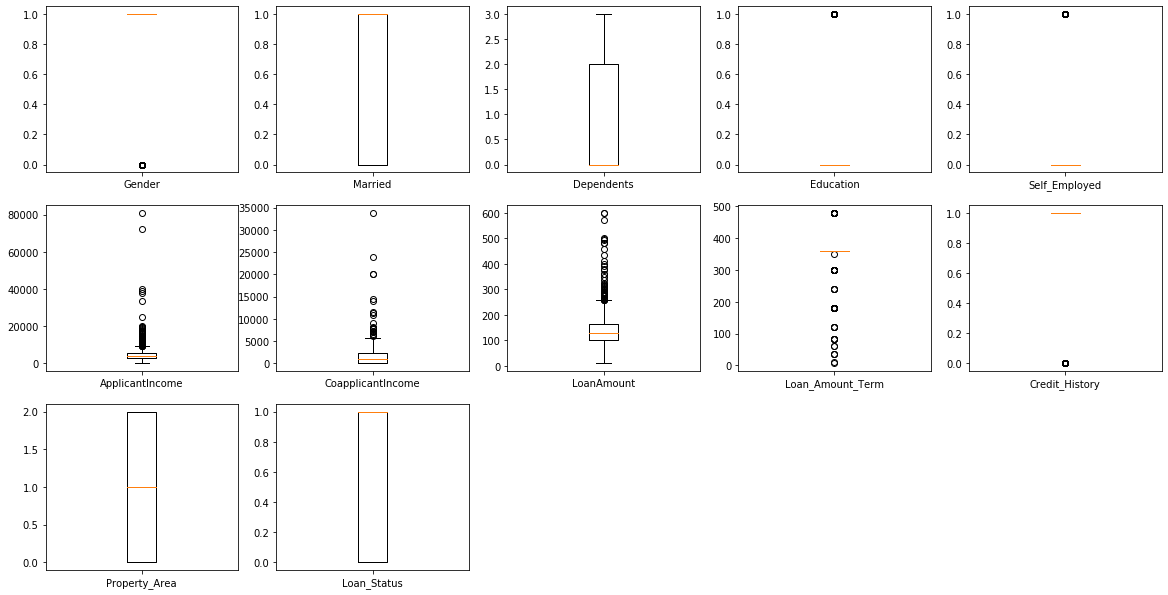

In [8]:
# box and whisker plots
seperate_boxplot(df, figsize=(20,25))
plt.show()

<p>With this dataset we have a few problems. The first problem is that many of the parameters need to be encoded into integer values because they are string values; but this is easily remedied by using the LabelEncoder from Scikit-Learn; however it should be noted that this may not give the best values to represent the data.<br> The second problem is in regards to having an unbalanced dataset which is seen in the class distribution; this could be remedied by resampling the dataset in a meaningful manner and is explored later.<br>Other than those problems looking at the box and whisker plots shows that for most features there are no outliers, but there are outliers for the continuous variables like income, loan amount, and the term of the loan.</p>

In [9]:
# reshape dataset and split into testing and training points
# also remove the Load_ID since it is meaningless for our purpose
X = df.iloc[:, :-1].values
y = df['Loan_Status'].values
X_train, y_train, X_val, y_val, X_test, y_test= dataset_split(X, y)

# print sizes of testing and training sets
print("#Original data points:",  X.shape[0])
print('#Training data points: %d' % X_train.shape[0])
print('#Validation data points: %d' % X_val.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

#Original data points: 769
#Training data points: 539
#Validation data points: 154
#Testing data points: 76


<p>Since we are splitting the data on our own, we combine the training and validation datasets to increase the number of data examples while being able to control the split of data. Splitting the data set into 3 subsets allows us to have data for different purposes; the main ones being: training, validation,and testing. </p>

In [10]:
def train_dev_split(X, y, dev_size=0.25):
    # calculate length of training set
    train_len = int(round(len(X)*(1-dev_size)))
    # return split data
    return X[0:train_len], y[0:train_len], X[train_len:None], y[train_len:None]

In [11]:
def _normalize_columns_0_1(X, train=True, specified_column=None, X_min = None, X_max=None):
    '''
        Function that takes in a Pandas dataframe and normalizes the 
        specified columns between 0 and 1.
        
        Inputs:
            - X: Pandas Dataframe
            - train: bool
            - specified_column: list of strings
            - X_min: float
            - X_max: float
        Outputs:
            - X: Pandas Dataframe with normalized columns
            - X_max: float
            - X_min: float
    '''
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        
        length = len(specified_column)
        X_max = np.reshape(np.max(X[:, specified_column], 0), (1, length))
        X_min = np.reshape(np.min(X[:, specified_column], 0), (1, length))
        
    X[:, specified_column]= np.divide(np.subtract(X[:, specified_column], 
                                                  X_min), np.subtract(X_max, X_min))
    
    return X, X_max, X_min

In [12]:
def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    '''
        Function that takes in a Pandas dataframe and normalizes the 
        specified columns centered around 0.
        
        Inputs:
            - X: Pandas Dataframe
            - train: bool
            - specified_column: list of strings
            - X_mean: float
            - X_std: float
        Outputs:
            - X: Pandas Dataframe with normalized columns
            - X_mean: float
            - X_std: float
    '''
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
    
    length = len(specified_column)
    X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
    X_std = np.reshape(np.std(X[:, specified_column], 0), (1, length))
    
    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
    
    return X, X_mean, X_std

In [13]:
# These are the columns that I want to normalize
#X_train, X_mean, X_std = _normalize_columns_0_1(X_train)
X_train, X_mean, X_std = _normalize_column_normal(X_train)

In [14]:
#X_test, X_mean, X_std = _normalize_columns_0_1(X_test)
X_val, X_mean, X_std = _normalize_column_normal(X_val)

<p>Normalizing data allows for better representation of data, and reduces the difference in scale between different data features. For our dataset normalizing data worked better than rescaling the data between 0 and 1.</p>

<h2>Logistic Regression</h2>
<p>Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).<br>Using an activation function such as sigmoid which calculates the probability of the output to correspond to class label 0 works especially well for binary regression.</p>

In [15]:
def _sigmoid(z):
    # sigmoid function can be used to output probability
    z = np.array(z, dtype=np.float32)
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)
def get_prob(X, w, b):
    # the probability to output 1
    return _sigmoid(np.add(np.matmul(X, w), b))
def infer(X, w, b):
    # use round to infer the result
    return np.round(get_prob(X, w, b))
def _cross_entropy(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy
def _gradient(X, Y_label, w, b):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad
def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)+lamda*w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad
def _loss(y_pred, Y_label, lamda, w):
    return _cross_entropy(y_pred, Y_label) + lamda * np.sum(np.square(w))
def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc

In [16]:
def train(X_train, Y_train, max_iter=40):
    # split a validation set
    dev_size = 0.1155
    X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)
    
    # Use 0 + 0*x1 + 0*x2 + ... for weight initialization
    w = np.zeros((X_train.shape[1],))
    b = np.zeros((1,))
    
    regularize = True
    
    if regularize:
        lamda = 0.001
    else:
        lamda = 0
    
    batch_size = 32 # number to feed in the model for average to avoid bias
    learning_rate = 0.01 # how much the model learn for each step
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    step = 1
    
    loss_train = []
    loss_validation = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(max_iter):
        #print("Epoch:", epoch+1)
        # Random shuffle for each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)
        total_loss = 0.0
        
        # Logistic regression train with batch
        for idx in range(int(np.floor(len(Y_train)/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]
           
            # Find out the gradient of the loss
            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)
            
            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad
            
            step = step+1
    
        # Compute the loss and the accuracy of the training set and the validation set
        y_train_pred = get_prob(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)
    
        y_dev_pred = get_prob(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(accuracy(Y_dev_pred, Y_dev))
        loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)
    return w, b, loss_train, loss_validation, train_acc, dev_acc # return loss for plotting

In [17]:
# since we will be using K-Fold cross validation we don't need a seperate
# testing and training test set

X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((y_train, y_val))

In [18]:
k_fold = StratifiedKFold(shuffle=True)

r_2_scores_folds = []
mse_scores_folds = []
results_folds = []
class_labels_folds = []
weight_folds = []


for train_index, test_index in k_fold.split(X_combined, Y_combined):
    # return loss is to plot the result
    w, b, loss_train, loss_validation, train_acc, dev_acc=train(X_combined[train_index], Y_combined[train_index], 1000)
    
    # predict labels for test data
    result = infer(X_combined[test_index], w, b)
    
    results_folds.append(result)
    class_labels_folds.append(Y_combined[test_index])
    mse_scores_folds.append(mean_squared_error(Y_combined[test_index], result))
    r_2_scores_folds.append(r2_score(Y_combined[test_index], result))
    weight_folds.append(w)

In [19]:
# combine results from folds
w = np.average(weight_folds, axis=0)
results_folds = np.concatenate(results_folds).ravel()
class_labels_folds = np.concatenate(class_labels_folds).ravel()

Average MSE 0.14142425190282557
Average R^2 score 0.2824958790749797


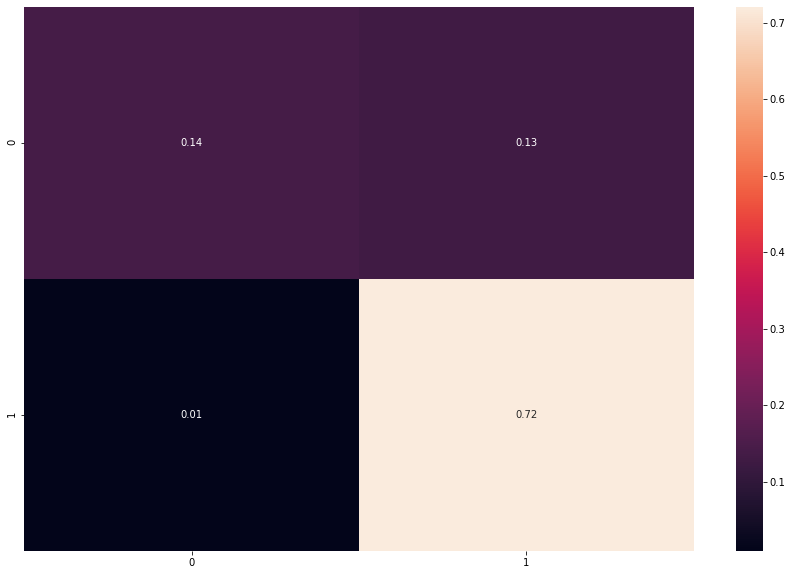

In [20]:
print('Average MSE', np.average(mse_scores_folds))
print('Average R^2 score', np.average(r_2_scores_folds))
# confusion matrix to compare prediction
plt.figure(figsize=(15,10))
heatmap(confusion_matrix(class_labels_folds, results_folds, labels=[0,1], normalize='all'), annot=True)
plt.show()

# plot the loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()

# plot the accuracy during training
plt.figure(figsize=(15,10))
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()

In [21]:
with open('output/results_nonresampled.txt', 'w') as f:
    f.write('id,label\n')
    for i, v in enumerate(result):
        f.write('%d,%d\n' %(i+1, v))

In [22]:
ind = np.argsort(np.abs(w))[::-1]
for i in ind:
    print(df.columns[i], w[i])

Credit_History 0.504080088474336
Married 0.07481343000980209
Education -0.061074656503244784
LoanAmount -0.05435377689117388
Property_Area 0.049453650656840646
CoapplicantIncome -0.042859250013530435
Dependents 0.024848187817116993
Gender 0.01959254523308792
ApplicantIncome 0.006039569801686207
Loan_Amount_Term -0.004889721229544942
Self_Employed -0.0008244191599739827


<p>Looking at the graph of the loss and accuracy during training shows that the model does reduce loss over each epoch, but the overall accuracy for training and dev subsets does not improve during training. After some testing we added K-Fold cross validation due to the inconsistency of training with such a small dataset. We take the average of the R^2 and MSE scores, and the weights to get a generalized score of the performance of the model. <br>The model also predicts class 1 more than class 0 most likely due to the imbalance in the dataset skewing the model to achieve a better score by predicting class 1 more often. This in trun led to a low R^2 score, even though MSE is quite low.<br>Looking at the weights of the model we can tell that the model focuses highly on Credit_Historay and Married while only barely taking into account other data features. </p>

<h2>Resampling The Dataset</h2>

In [23]:
# reshape dataset and split into testing and training points
X = df.iloc[:, :-1].values
y = df['Loan_Status'].values
sampler = imblearn.over_sampling.KMeansSMOTE(cluster_balance_threshold='auto')
X_res, y_res = sampler.fit_resample(X, y)

In [24]:
# display class distribution
y, counts = np.unique(y_res, return_counts=True)
for i in range(len(counts)):
    print('%i:'%i, counts[i])

0: 561
1: 561


In [25]:
X_train, y_train, X_val, y_val, X_test, y_test= dataset_split(X_res, y_res)

# print sizes of testing and training sets
print("#Original data points:",  X_res.shape[0])
print('#Training data points: %d' % X_train.shape[0])
print('#Validation data points: %d' % X_val.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

#Original data points: 1122
#Training data points: 786
#Validation data points: 225
#Testing data points: 111


In [26]:
# These are the columns that I want to normalize
#X_train, X_mean, X_std = _normalize_columns_0_1(X_train)
X_train, X_mean, X_std = _normalize_column_normal(X_train)

In [27]:
#X_test, X_mean, X_std = _normalize_columns_0_1(X_test)
X_val, X_mean, X_std = _normalize_column_normal(X_val)

In [28]:
# since we will be using K-Fold cross validation we don't need a seperate
# testing and training test set

X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((y_train, y_val))

In [29]:
k_fold = KFold(shuffle=True)

r_2_scores_folds = []
mse_scores_folds = []
results_folds = []
class_labels_folds = []
weight_folds = []


for train_index, test_index in k_fold.split(X_combined, Y_combined):
    # return loss is to plot the result
    w, b, loss_train, loss_validation, train_acc, dev_acc=train(X_combined[train_index], Y_combined[train_index], 1000)
    
    # predict labels for test data
    result = infer(X_combined[test_index], w, b)
    
    results_folds.append(np.array(result, dtype=np.uint8))
    class_labels_folds.append(np.array(Y_combined[test_index], dtype=np.uint8))
    mse_scores_folds.append(mean_squared_error(Y_combined[test_index], result))
    r_2_scores_folds.append(r2_score(Y_combined[test_index], result))
    weight_folds.append(w)

# measurements of performance
print('Average MSE', np.average(mse_scores_folds))
print('Average R^2 score', np.average(r_2_scores_folds))

Average MSE 0.09889284494951958
Average R^2 score 0.603578900851525


In [30]:
# combine results from folds
w = np.average(weight_folds, axis=0)
results_folds = np.concatenate(results_folds).ravel()
class_labels_folds = np.concatenate(class_labels_folds).ravel()

Average MSE 0.09889284494951958
Average R^2 score 0.603578900851525


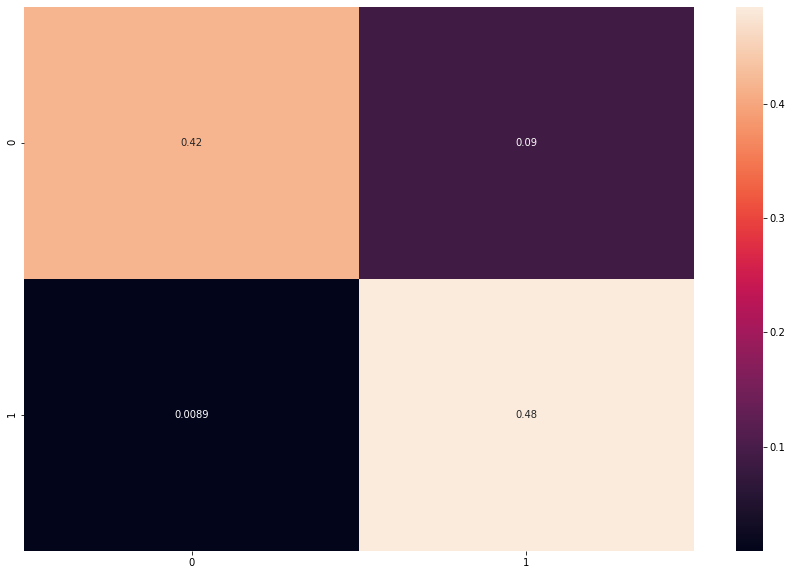

In [31]:
print('Average MSE', np.average(mse_scores_folds))
print('Average R^2 score', np.average(r_2_scores_folds))
# confusion matrix to compare prediction
plt.figure(figsize=(15,10))
heatmap(confusion_matrix(class_labels_folds, results_folds, labels=[0,1], normalize='all'), annot=True)
plt.show()

# plot the loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()

# plot the accuracy during training
plt.figure(figsize=(15,10))
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()

In [32]:
with open('output/results_resampled.txt', 'w') as f:
    f.write('id,label\n')
    for i, v in enumerate(result):
        f.write('%d,%d\n' %(i+1, v))

In [33]:
ind = np.argsort(np.abs(w))[::-1]
for i in ind:
    print(df.columns[i], w[i])

CoapplicantIncome -0.588767181319478
Credit_History 0.5275997805110055
Married 0.21743371140914505
ApplicantIncome 0.1547605549670094
Self_Employed -0.14669045651093618
LoanAmount -0.12125718821568879
Gender -0.08933060929899515
Loan_Amount_Term -0.07035483971073433
Education 0.06818285156104384
Property_Area -0.05987718956466328
Dependents 0.014225174373455865


<p>With resampling the dataset the model has a more balanced representation of each class and is able to better learn the features that distinguish classes. Compared to the nonresampled weights; the model trained on resampled data puts more emphasis on <code>Credit_History, CoapplicantIncome, and LoanAmount</code>; which makes sense since a good <code>Credit_History</code> shows consistency in making payments, the <code>CoapplicantIncome</code> is not that important since they are not responsible for paying back the loan, and the LoanAmount could cause loaners to deny the loan if the amount is too high. Not only that, but the MSE and R^2 scores increased as well and this is evident in the confusion matrices between the unsampled and resampled data.<br> Resampling did not help to overcome the overfitting in the model, but it did help alleviate the problem of more prediction of one class over the other; which can be seen in the confusion matrices above.</p>

<h2>Final Remarks</h2>
<ul>
    <li>Logistic Regression is a probabalistic model which calculated the probability of one class in comparison to the others. Utilizing activation functions such as Sigmoid allow for easy calculation of these percentages and works well for problems with only 2 classes.</li>
    <li>Inequality with the number fo classes can lead to a certain "performance paradox" in which the model achieve good marks during training, but when looking at the confusion matrix it can be seen that the model is achieving good perforamnce by estimating the most prevelant class in the dataset.</li>
    <li>Resampling the dataset could help improve performance either utilizing over sampling or under sampling. Since there is a small number of data we utilize over sampling to counteract the class inequality.</li>
</ul>